Portfolio Optmization using Python and Monte Carlo Simulation Technique

In [55]:
import pathlib as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from sklearn.preprocessing import StandardScaler
import sys

sys.path.append(".")
from get_price_data import PriceData

# Set some display options for Pandas.
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

In [56]:
# Define the symbols
symbols = ["JNJ", "MMM", "T", "DIS", "KO"]

# At different points, we will need to generate metrics based on the number
# of symbols we have, so let's save some time and just calculate that now.
num_of_symbols = len(symbols)

# Instantiate PriceData to get price data if needed
priceData = PriceData()

pathToPriceData = "..\data\stock_data_test2.csv"

# If we have data, read it
if pl.Path(pathToPriceData).exists():
    # Load the data.
    price_df: pd.DataFrame = pd.read_csv(pathToPriceData)
    print("running")

else:
# If we don't have data get it from yahoo finance
    for symbol in symbols:
        priceData.copyToCsv(pathToPriceData, symbol)

    price_df: pd.DataFrame = pd.read_csv(pathToPriceData)


running


In [57]:
# Get needed columns from data
price_df = price_df[['date', 'symbol', 'close']]

# Pivot columns to where we index by date, columns (names) is symbol and values are close
price_df = price_df.pivot(index='date', columns='symbol', values='close')

In [58]:
# Calculating the log returns of our selected tickers
# Why the log returns? Makes our data more normally distributed and can help achieve constant variance over time
# Disadvantage: not portfolio additive, log returns does not necessarily equal weighted return

# Gives us percent change over time
log_return = np.log(1 + price_df.pct_change())

# Generate random weights of each stock
random_weights = np.array(np.random.random(num_of_symbols))

# Generate rebalanced weights so they sum to 1
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate expected annualized (252 days) returns of the entire portfolio
exp_return = np.sum(log_return.mean() * rebalance_weights * 252)

# Calculate expected annualized volatility of the entire portfolio
exp_volatility = np.sqrt(
  np.dot(
    rebalance_weights.T,
    np.dot(
      log_return.cov() * 252,
      rebalance_weights
    )
  )
)

# Calculate Sharpe Ratio, first determine your risk free rate
risk_free_rate = 0.01
sharpe_ratio = (exp_return - risk_free_rate) / exp_volatility


In [59]:
# Select the number of times to run simulation which will create the same number of porfolios
num_of_portfolios = 10000

# create an 2d array with zeros that is the size of num_of_portfolios x num_of_symbols
all_weights = np.zeros((num_of_portfolios, num_of_symbols))

all_exp_returns = np.zeros(num_of_portfolios)
all_exp_volatilities = np.zeros(num_of_portfolios)
all_sharpe_ratios = np.zeros(num_of_portfolios)

# Run simulations
for sim in range(num_of_portfolios):
    # Calculate (rebalanced) weights
    weights = np.array(np.random.random(num_of_symbols))
    weights /= np.sum(weights)

    # Add weights to array
    all_weights[sim] = weights

    # Calculated expected return and add to array
    all_exp_returns[sim] = np.sum(log_return.mean() * weights * 252)

    # Add expected volatility to array
    all_exp_volatilities[sim] = np.sqrt(
                                    np.dot(
                                        weights.T,
                                        np.dot(
                                        log_return.cov() * 252,
                                        weights
                                        )
                                    )
                                )
    
    # Add sharpe ratio to array
    all_sharpe_ratios[sim] = (all_exp_returns[sim] - risk_free_rate) / all_exp_volatilities[sim]


In [60]:
# Create data frame for tickers and weights
weights_data = [all_weights[:, ind] for ind in range(num_of_symbols)]

weights_df = pd.DataFrame(weights_data).T
weights_df.columns = symbols

In [61]:
# Create data frame for metrics calculated
metrics_data = {"Return": all_exp_returns, "Volatility": all_exp_volatilities, "Sharpe Ratio": all_sharpe_ratios}
metrics_df = pd.DataFrame(metrics_data)

# Create master dataframe: metrics and weights
sim_df = pd.concat([metrics_df, weights_df], axis = 1)

In [62]:
# Get max Sharpe Ratio from simulations
max_sharpe_ratio = sim_df.loc[sim_df["Sharpe Ratio"].idxmax()]

# Get min volatility from simulations
min_volatility = sim_df.loc[sim_df["Volatility"].idxmin()]

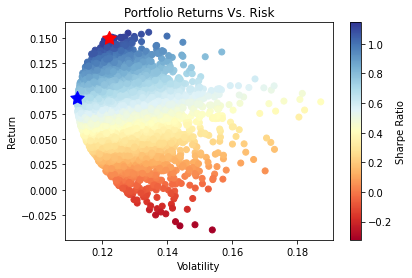

Max sharpe Ratio (red star): 
Return          0.149944
Volatility      0.122210
Sharpe Ratio    1.145107
JNJ             0.075846
MMM             0.634843
T               0.075674
DIS             0.180265
KO              0.033373
Name: 5086, dtype: float64
Min volatility (blue star): 
Return          0.090208
Volatility      0.112384
Sharpe Ratio    0.713690
JNJ             0.091538
MMM             0.347839
T               0.274323
DIS             0.110092
KO              0.176208
Name: 2385, dtype: float64


In [63]:
# Plot the data on a Scatter plot.
plt.scatter(
    y=sim_df["Return"],
    x=sim_df["Volatility"],
    c=sim_df["Sharpe Ratio"],
    cmap="RdYlBu"
)

plt.title("Portfolio Returns Vs. Risk")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")

# Plot the max sharpe ratio as a "red star"
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color="r",
    s=200
)

# Plot the min volatility as a "blue star"
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color="b",
    s=200
)

plt.show()
print("Max sharpe Ratio (red star): ")
print(max_sharpe_ratio)
print("Min volatility (blue star): ")
print(min_volatility)